In [25]:
import pandas as pd
import numpy as np
import prince 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 
import seaborn as sns

In [26]:
# Importation de la base et visualisation des données 
df = pd.read_csv("C:\\Users\\Home\\Desktop\\Statapp\\series_progress_sampled.csv")
df.head(5)

C:\Users\Home\AppData\Local\Temp\ipykernel_9340\1811976592.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\Home\\Desktop\\Statapp\\series_progress_sampled.csv")


,learner_id,unique_learner_id,creation_serie,score,series_id,status,type,is_freemium,score_pct,training_session_id,is_before_theory_exam_success,course_id,course_name,course_order
0,2364513,-92590771937651771,2021-10-01T19:01:16.000Z,16.0,9111,complete,exam,0,0.400,302234e2-7f5c-415a-ad46-f77067fb6da4,True,NaN,NaN,NaN
1,1987716,3392312726569945104,2021-08-18T22:59:12.000Z,19.0,6967,complete,exam,0,0.475,07efe275-053d-4dc6-943e-4db2835ccc01,True,NaN,NaN,NaN
2,304008,-1708221254721400777,2021-08-07T16:58:46.000Z,19.0,6247,complete,exam,0,0.475,fdaa6cf0-391f-46be-bcd0-2733da668d43,True,NaN,NaN,NaN
3,584245,-2588731723289132657,2019-06-16T11:02:52.000Z,18.0,71,complete,exam,0,0.450,20d4b7f2-6c48-42e6-88a6-21ca16d20265,True,NaN,NaN,NaN
4,1276434,-479177578173813811,2021-01-31T21:30:01.000Z,14.0,156,complete,exam,0,0.350,aa849f7e-4d50-4780-b6a0-7feb3cfe09cc,False,NaN,NaN,NaN


In [93]:
df["score_pct"].value_counts()

0.800    344575
0.900    302767
0.700    284803
1.000    216362
0.600    185563
0.825    150408
0.850    145654
0.775    145479
0.875    138605
0.750    136014
0.725    125081
0.925    102059
0.500     99888
0.675     98739
0.650     84449
0.950     83958
0.625     71839
0.975     70114
0.575     49028
0.400     45089
0.550     39337
0.525     30914
0.475     18297
0.300     16329
0.450     13313
0.425      9826
0.375      4795
0.200      4790
0.350      3227
0.325      2109
0.100       995
0.275       825
0.000       719
0.250       583
0.025       475
0.225       403
0.175       191
0.150       148
0.125       117
0.050       112
0.075        88
Name: score_pct, dtype: int64

0.7667634500822779

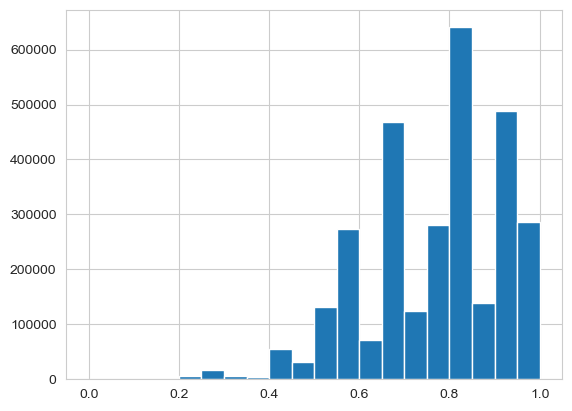

In [94]:
# disctribution des score en pourcentage
df["score_pct"].hist(bins=20)
df["score_pct"].mean()

In [3]:
# Création d'une nouvelle variable qui qualifie le score : score_pct_qual
tm = pd.Interval(-1,0.5,closed='right')
m = pd.Interval(0.5,0.7,closed='right')
bon = pd.Interval(0.7,0.9,closed='right')
tbon = pd.Interval(0.9,1.0 ,closed='right')

df["score_pct_qual"] = df["score_pct"].map({tm:"tres_mauvais",
                                           m:"mauvais",
                                           bon : "bon",
                                           tbon:"tres_bon"},
                                            na_action = None)
df.head(5)
df["score_pct_qual"].value_counts().sum()

3028067

In [4]:
# Création de df2, trié pour créer une nouvelle variable n_th_serie, qui vaut n si cette série est la n-ième série du learner:

df2 = df.sort_values('creation_serie')
df2.reset_index(drop = True,inplace = True)
df2['n_th_series'] = df2.groupby('learner_id').cumcount()

In [4]:
df2.head(10)

,learner_id,unique_learner_id,creation_serie,score,series_id,status,type,is_freemium,score_pct,training_session_id,is_before_theory_exam_success,course_id,course_name,course_order,n_th_series
0,9045,751634657445133149,2016-04-11T14:53:42.000Z,36.0,70,complete,training,0,0.900,c8f3b678-54c8-4ffc-97f4-96cb078bfd1d,True,NaN,NaN,NaN,0
1,5623,3466993288107043352,2016-04-11T20:35:09.000Z,29.0,70,complete,training,0,0.725,412ee334-7819-41b2-8db3-1925c8293ab3,True,NaN,NaN,NaN,0
2,5623,3466993288107043352,2016-04-11T20:42:19.000Z,29.0,71,complete,training,0,0.725,6fcf47d8-d25a-4a14-9c62-186d5bdec4c2,True,NaN,NaN,NaN,1
3,5623,3466993288107043352,2016-04-11T20:47:53.000Z,27.0,72,complete,exam,0,0.675,1a8bfd38-5b96-40a5-9dbe-fffa85b2fd1f,True,NaN,NaN,NaN,2
4,5623,3466993288107043352,2016-04-11T20:55:08.000Z,30.0,73,complete,training,0,0.750,3d61a0f6-710f-4e1c-84b9-a3afe09a7ffe,True,NaN,NaN,NaN,3
5,5623,3466993288107043352,2016-04-11T21:02:49.000Z,25.0,74,complete,training,0,0.625,12322950-d360-44c7-81ca-4d77a4a54384,True,NaN,NaN,NaN,4
6,8681,-4618888821379456981,2016-04-12T11:22:42.000Z,25.0,70,complete,training,0,0.625,6c4c684d-05e7-4731-b81c-8b2b88ba3ab6,True,NaN,NaN,NaN,0
7,8681,-4618888821379456981,2016-04-12T11:36:28.000Z,25.0,71,complete,training,0,0.625,27566cb1-fc8a-4055-b94e-785262911a79,True,NaN,NaN,NaN,1
8,9176,6432112278089974199,2016-04-12T15:59:09.000Z,20.0,70,complete,training,0,0.500,33312aee-a865-4439-b728-374c4c6a9974,True,NaN,NaN,NaN,0
9,7696,-2942304359049808076,2016-04-12T18:20:28.000Z,23.0,70,complete,training,0,0.575,2b6931e8-6456-48a1-a947-b15c5db31813,True,NaN,NaN,NaN,0


In [5]:
# suppression des colonnes non numériques
dfNan = df.fillna(9999)
# ACP sur les variables quantitatives (series_id juste pour tester sur plus de 2 variables)
df_N = dfNan[["score","score_pct","series_id"]]
pca = PCA()
pca.fit(df_N)

PCA()

In [6]:
pca.explained_variance_

array([8.65163228e+07, 4.07331132e+07, 4.75289859e+01])

In [7]:

eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(3)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,8.651632e+07,68.0,68.0
1,Dim2,4.073311e+07,32.0,100.0
2,Dim3,4.752899e+01,0.0,100.0


# Réalisation de la première réduction de dimension sur les variables qualitatives - ACM

In [8]:
import prince #pour réaliser une ACM
#!pip install prince --user

In [9]:
# Création d'une nouvelle variable qualitative pour "is_before_theory_exam_success_qual"
df["is_before_theory_exam_success_qual"] = df["is_before_theory_exam_success"].map({True:"T",
                                                                              False:"F"},
                                                                             na_action = None)
df2["is_before_theory_exam_success_qual"] = df2["is_before_theory_exam_success"].map({True:"T",
                                                                              False:"F"},
                                                                             na_action = None)

df.head(5)

,learner_id,unique_learner_id,creation_serie,score,series_id,status,type,is_freemium,score_pct,training_session_id,is_before_theory_exam_success,course_id,course_name,course_order,score_pct_qual,is_before_theory_exam_success_qual
0,2364513,-92590771937651771,2021-10-01T19:01:16.000Z,16.0,9111,complete,exam,0,0.400,302234e2-7f5c-415a-ad46-f77067fb6da4,True,NaN,NaN,NaN,tres_mauvais,T
1,1987716,3392312726569945104,2021-08-18T22:59:12.000Z,19.0,6967,complete,exam,0,0.475,07efe275-053d-4dc6-943e-4db2835ccc01,True,NaN,NaN,NaN,tres_mauvais,T
2,304008,-1708221254721400777,2021-08-07T16:58:46.000Z,19.0,6247,complete,exam,0,0.475,fdaa6cf0-391f-46be-bcd0-2733da668d43,True,NaN,NaN,NaN,tres_mauvais,T
3,584245,-2588731723289132657,2019-06-16T11:02:52.000Z,18.0,71,complete,exam,0,0.450,20d4b7f2-6c48-42e6-88a6-21ca16d20265,True,NaN,NaN,NaN,tres_mauvais,T
4,1276434,-479177578173813811,2021-01-31T21:30:01.000Z,14.0,156,complete,exam,0,0.350,aa849f7e-4d50-4780-b6a0-7feb3cfe09cc,False,NaN,NaN,NaN,tres_mauvais,F


In [10]:
# On remplace les Nan 
dfACM = df2.fillna('')[["is_before_theory_exam_success_qual","type","status","course_name" ]]

In [11]:
#Réalisation de l'ACM
mca = prince.MCA()
mca = mca.fit(dfACM)

In [12]:
mca.eigenvalues_,mca.total_inertia_,mca.explained_inertia_,

([0.402547762139298, 0.2887719514718886],
 3.75,
 [0.1073460699038128, 0.07700585372583696])

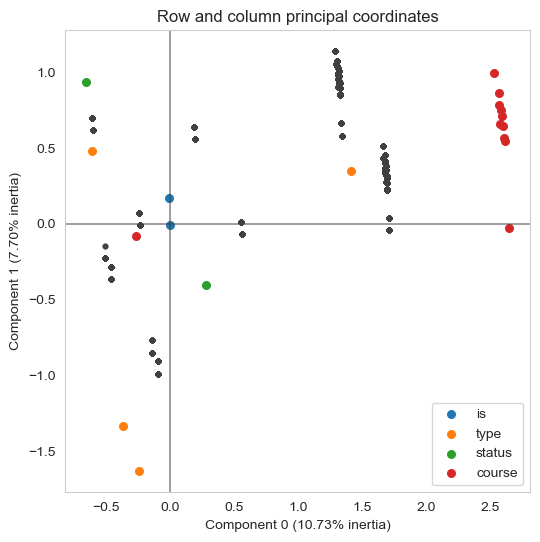

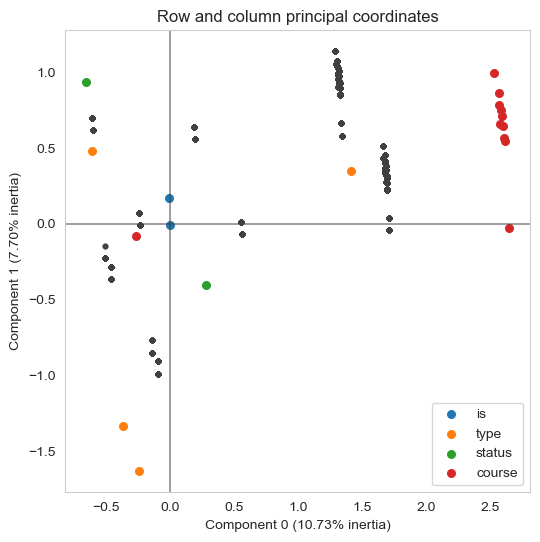

In [149]:
mca.explained_inertia_

ax = mca.plot_coordinates(
     X=dfACM,
     ax=None,
     figsize=(6, 6),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
 )
ax.get_figure()

# Récupération de deux composantes de l'ACM pour résumer l'information des variables qualitatives 

In [13]:
mca_transformed = mca.transform(dfACM)


In [14]:
mca_transformed.head(5)

,0,1
0,-0.234450,-0.021888
1,-0.234450,-0.021888
2,-0.234450,-0.021888
3,-0.090234,-0.986256
4,-0.234450,-0.021888


In [15]:
#df_ACM_output = df[["learner_id", "unique_learner_id"]]
df_ACM_output = df2[["learner_id"]]
df_ACM_output[["score_ACM_1","score_ACM_2"]] = mca_transformed 
df_ACM_output[["score_pct","n_th_series"]] = df2[["score_pct","n_th_series"]]

C:\Users\Home\AppData\Local\Temp\ipykernel_9340\267127707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_output[["score_ACM_1","score_ACM_2"]] = mca_transformed
C:\Users\Home\AppData\Local\Temp\ipykernel_9340\267127707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_output[["score_ACM_1","score_ACM_2"]] = mca_transformed
C:\Users\Home\AppData\Local\Temp\ipykernel_9340\267127707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

**On a maintenant un dataframe qui comporte 4 variables quantitatives par séries sur lequel on va réaliser une nouvelle réduction de dimension, cette fois ci une ACP. Cela nous permet d'afficher des cercles de corrélations pour mieux identifier quelles sont les variables réellement explicatives de la variance.**

In [16]:
df_ACM_output.head(5)

,learner_id,score_ACM_1,score_ACM_2,score_pct,n_th_series
0,9045,-0.234450,-0.021888,0.900,0
1,5623,-0.234450,-0.021888,0.725,0
2,5623,-0.234450,-0.021888,0.725,1
3,5623,-0.090234,-0.986256,0.675,2
4,5623,-0.234450,-0.021888,0.750,3


Pour l'instant nous avons rempli les valeurs Nan avec des 0 en attendant de trouver une solution plus convaincante. 

In [17]:
df_ACM_output_N = df_ACM_output.fillna(0)
# ACP sur les variables quantitatives 
df_ACM_output_Normalize = normalize(df_ACM_output_N[["score_ACM_1","score_ACM_2","score_pct","n_th_series"]])
pca = PCA()
pca.fit(df_ACM_output_Normalize)

PCA()

In [18]:
pca.explained_variance_

array([0.01727598, 0.00383277, 0.00191318, 0.00106926])

In [19]:
eig = pd.DataFrame(
    {
        "Dimension" : ["n=" + str(x + 1) for x in range(4)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig


,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,n=1,0.017276,72.0,72.0
1,n=2,0.003833,16.0,88.0
2,n=3,0.001913,8.0,96.0
3,n=4,0.001069,4.0,100.0


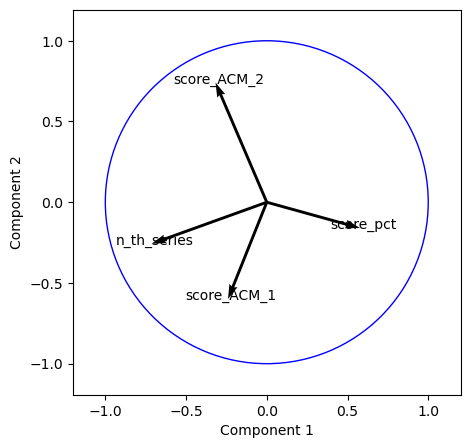

In [20]:
# Get the PCA components (loadings)
PCs = pca.components_

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(5,5))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)

# Add labels based on feature names (here just numbers)
feature_names = ["score_ACM_1","score_ACM_2","score_pct","n_th_series"]
for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
    plt.text(j, i, z, ha='center', va='center')

# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
plt.axis('equal')
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])

# Label axes
plt.title('Correlation Circle')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Done
plt.show()

In [22]:
coords = pca.fit_transform(df_ACM_output_Normalize)
df_pca_output = pd.DataFrame(coords)

In [23]:
df_pca_output[["learner_id"]]=df2[["learner_id"]]

In [24]:
df_pca_output.columns = ['Score_PCA_1', 'Score_PCA_2', 'Score_PCA_3', 'Score_PCA_4', 'learner_id']


In [25]:
df_pca_output

,Score_PCA_1,Score_PCA_2,Score_PCA_3,Score_PCA_4,learner_id
0,1.291410,0.343105,-0.366581,0.107670,9045
1,1.296750,0.370654,-0.326688,0.076243,5623
2,0.489082,0.130351,-0.286427,-0.199451,5623
3,0.397444,-0.290507,0.009278,-0.144884,5623
4,0.152449,0.040276,-0.128630,-0.111825,5623
...,...,...,...,...,...
4342708,-0.026447,0.027534,0.009861,-0.002817,2471785
4342709,-0.019205,-0.001721,0.015763,-0.002935,831433
4342710,-0.029668,0.007014,0.001166,0.011358,2596823
4342711,-0.023245,-0.001781,0.006916,0.004948,2724959


# On va maintenant garder la première composante de cette ACP, bien représentée par la variable score_pct pour réaliser la deuxième réduction de dimension au niveau des learner.

In [26]:
df_pca_output.drop(['Score_PCA_2', 'Score_PCA_3', 'Score_PCA_4'], axis=1)

,Score_PCA_1,learner_id
0,1.291410,9045
1,1.296750,5623
2,0.489082,5623
3,0.397444,5623
4,0.152449,5623
...,...,...
4342708,-0.026447,2471785
4342709,-0.019205,831433
4342710,-0.029668,2596823
4342711,-0.023245,2724959


In [28]:
df_learner=pd.pivot_table(df_pca_output,index=['learner_id'],columns=df_ACM_output.groupby(['learner_id']).cumcount().add(1),values=['Score_PCA_1'],aggfunc='sum')
df_learner.columns=df_learner.columns.map('{0[0]}{0[1]}'.format) 


Le tableau df_learner donne le score de la composante 1 de l'ACP par learner dans l'odre chronologique de leur séries. La colonne Score_PCA_11 donne donc la coordonnées suivant la première composante de l'ACP pour la première série effectuée par le learner.

In [29]:
df_learner.head(5)

,Score_PCA_11,Score_PCA_12,Score_PCA_13,Score_PCA_14,Score_PCA_15,Score_PCA_16,Score_PCA_17,Score_PCA_18,Score_PCA_19,Score_PCA_110,...,Score_PCA_113380,Score_PCA_113381,Score_PCA_113382,Score_PCA_113383,Score_PCA_113384,Score_PCA_113385,Score_PCA_113386,Score_PCA_113387,Score_PCA_113388,Score_PCA_113389
learner_id,,,,,,,,,,,,,,,,,,,,,
77,1.289947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,1.346676,0.760906,0.471497,0.302800,0.138621,0.100954,0.076295,0.065703,0.048103,0.043142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,1.322822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,1.293681,0.736495,0.221762,0.146951,0.109948,0.084862,0.068378,0.047881,0.036600,0.029603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,0.598465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Le problème qu'on rencontre ici est qu'un grand nombre de learners n'ont fait que très peu de séries. On va donc resteindre le data frame df_learner pour ne garder que les learners avec un nombre raisonnable de séries (encore à déterminer proprement).**

On peut voir ce problème sur la fonction de répartition du nombre de séries par learner plot ci dessous

[Text(0.5, 0, 'Nombre de séries'), Text(0, 0.5, 'Proportion')]

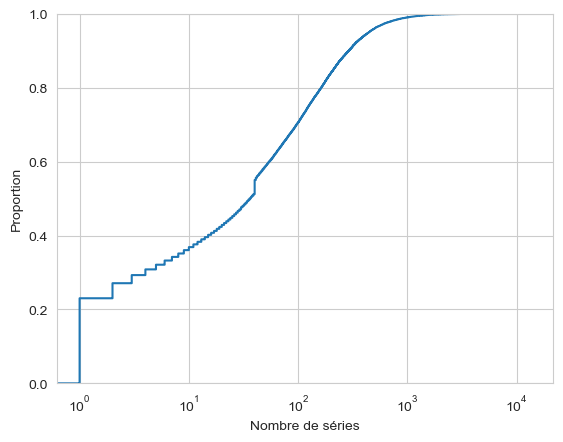

In [30]:
learner_count = df["learner_id"].value_counts()
sns.set_style("whitegrid")
plot = sns.ecdfplot(learner_count,log_scale = True )
plot.set(xlabel = "Nombre de séries", ylabel = "Proportion")

In [31]:
df_learner_cutted = df_learner.drop(df_learner.columns[[i for i in range(1001,13389)]], axis=1) 
df_learner_cutted.dropna(subset=['Score_PCA_150'],inplace = True)

In [32]:
df_learner_cutted

,Score_PCA_11,Score_PCA_12,Score_PCA_13,Score_PCA_14,Score_PCA_15,Score_PCA_16,Score_PCA_17,Score_PCA_18,Score_PCA_19,Score_PCA_110,...,Score_PCA_1992,Score_PCA_1993,Score_PCA_1994,Score_PCA_1995,Score_PCA_1996,Score_PCA_1997,Score_PCA_1998,Score_PCA_1999,Score_PCA_11000,Score_PCA_11001
learner_id,,,,,,,,,,,,,,,,,,,,,
89,1.346676,0.760906,0.471497,0.302800,0.138621,0.100954,0.076295,0.065703,0.048103,0.043142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
492,1.297495,0.089616,0.196985,0.114279,0.093807,0.062735,0.109179,0.034779,0.038504,-0.017991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1338,0.598465,0.089616,0.376632,-0.021831,0.028477,-0.010633,-0.026575,-0.012856,-0.024126,-0.007115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1432,1.346934,0.675048,0.390600,0.257774,0.188406,0.143724,0.040560,0.021573,0.022953,0.010557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2541,1.294451,0.552427,0.303623,0.174543,0.105894,0.104198,0.057928,0.050087,0.034700,0.031281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938310,1.356874,0.359913,-0.112593,-0.021831,0.061838,0.047267,0.051116,-0.004211,0.022953,0.010557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2939629,1.346934,0.359913,0.038425,-0.091154,0.073945,0.055225,0.051116,0.048334,0.030669,0.030931,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2940651,1.356874,0.420234,0.264510,0.095701,0.045866,0.055225,-0.000284,0.030393,0.000318,0.024073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Deuxième ACP au niveau learner

In [24]:
df_learner_PCA_N = df_learner_cutted.fillna(0)
# ACP sur les variables quantitatives 
df_learner_PCA_Normalize = normalize(df_learner_PCA_N)
pca = PCA()
pca.fit(df_learner_PCA_Normalize)

NameError: name 'df_learner_cutted' is not defined

In [34]:
pca.explained_variance_
eig = pd.DataFrame(
    {
        "Dimension" : ["n=" + str(x + 1) for x in range(len(df_learner_PCA_Normalize[0]))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig


,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,n=1,2.379291e-02,29.0,29.0
1,n=2,1.727343e-02,21.0,51.0
2,n=3,9.907950e-03,12.0,63.0
3,n=4,5.301527e-03,7.0,69.0
4,n=5,4.596630e-03,6.0,75.0
...,...,...,...,...
996,n=997,3.558022e-10,0.0,100.0
997,n=998,3.503590e-10,0.0,100.0
998,n=999,3.285336e-10,0.0,100.0
999,n=1000,3.087114e-10,0.0,100.0


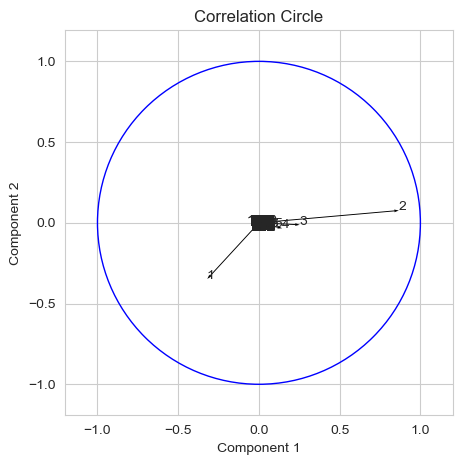

In [39]:
# Get the PCA components (loadings)
PCs = pca.components_

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(5,5))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)

# Add labels based on feature names (here just numbers)
feature_names = [str(i+1) for i in range(len(df_learner_PCA_Normalize[0]))]
for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
    plt.text(j, i, z, ha='center', va='center')

# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
plt.axis('equal')
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])

# Label axes
plt.title('Correlation Circle')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Done
sns.set_style("white")
plt.show()

In [38]:
!pip install mlxtend --user


     ---------------------------------------- 1.3/1.3 MB 3.6 MB/s eta 0:00:00
